# Analysis of Tuning Properties
This tutorial shows how to generate the plots showing how well the units are tuned to a particular kinematic feature as found in Figure 5 of the paper

In [1]:
#from pyglmnet import GLM
import numpy as np
import matplotlib
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#from dir_tuning_alllayers_mp import *
from rowwise_neuron_curves_controls import *
import pickle
import os
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from controls_main import RunInfo

# %% VARIABLES

muscle_order = ['CORB', 'DELT1', 'DELT2', 'DELT3', 'INFSP', 'LAT1', 'LAT2', 'LAT3', 'PECM1', 
                'PECM2', 'PECM3', 'SUBSC', 'SUPSP', 'TMAJ', 'TMIN', 'ANC', 'BIClong', 'BICshort', 
                'BRA', 'BRD', 'ECRL', 'PT', 'TRIlat', 'TRIlong', 'TRImed']

No module named 'tensorflow'
proceeding without savelouts , this will only work if no data is being generated


In [106]:
modelinfo = dict({'type': 'S',
            'base': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272',
            'name': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1',
            'shortbase': 'Spatial-Temporal',
            'shortname': 'Spatial-Temporal_1',
            'nlayers': 8,
            'max_act': 14,
            'control': False,
            'cmap': 'Blues_r',
            'color': 'C0',
            'control_cmap': 'Purples_r'})

runinfo = RunInfo({'expid': 102, #internal experiment id
                   'datafraction': 0.5,
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 0,
                   'model_experiment_id': 4, #as per Pranav's model generation
                   'basefolder' : '/home/kai/Dropbox/DeepDrawData/analysis-data/', #point to analysis-data folder
                       #in DeepDrawData folder from Dropbox, include trailing slash
                   'orientation' : 'hor',
                   'height' : 'all'
            })

## A: 2D Polar Scatter Plots

In [11]:
def get_thetas_rs_from_row(polar, acts, rowidx, tcoff=32):
    """Get matching thetas and activations (stored as Rs) 
    
    Arguments
    ---------
    polar : np.array [nr_samples, nr_components (rs, thetas), nr_timepoints], velocity vectors in polar representation
    acts : np.array, 3-dim for spindles and 4-dim for hidden layers, activation strength of units
    rowidx : tuple, 1-dim for spindles, 2-dim for hidden layers, which unit is being analyzed
    
    Returns
    -------
    thetas : np.array [nr_samples, nr_timepoints], theta component of velocity vector
    rs : np.array [nr_samples, nr_timepoints], activation strength of current unit
    """
    
    #print(rowidx, acts.shape)
    
    #select proper row
    thetas = polar[:,1]

    centers = get_centers(acts.shape[2])
    
    if(len(rowidx) == 1):
        nodeselector = (slice(None),) + rowidx
    else:
        nodeselector = (slice(None),) + tuple([rowidx[0]]) + (slice(None),) + tuple([rowidx[1]])
    
    acts = acts[nodeselector]
    
    #print(len(centers))
    #print(thetas.shape)
    #print(acts.shape)
    #select time interval
    
    fmtcoff = sum(np.where(centers <= tcoff, True, False))
    
    thetas = thetas[:,centers[fmtcoff:len(centers) - fmtcoff]]
    acts = acts[:,fmtcoff:acts.shape[1]-fmtcoff]
    
    nnas = np.invert(np.isnan(thetas))
    
    thetas = thetas[nnas]
    #rs = acts[nodeselector].squeeze()
    rs = acts[nnas]
    
    #in case of muscle spindles, introduce baseline offset
    if(len(rowidx)==1):
        rs = rs + 82
    
    return thetas, rs

specify which layer you want to print the tuning curves for

In [4]:
ilayer = 3

select top 5 nodes (both for best direction-tuned and best direction-velocity tuned)

In [12]:
dirmi = []
dvmi = [] #store max indices in nested list

kbest = 5
mmod = 'std'
fset = 'vel'

evals = np.load(os.path.join(runinfo.resultsfolder(modelinfo, 'vel'), 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, fset, mmod, runinfo.planestring())))
r2 = evals[...,1]
#mcboxplot(r2, 'r2 Score', ilayer);
dirtuning = np.copy(r2[...,1])
dirtuning[dirtuning == 1] = -1
dvtuning = np.copy(r2[...,3])
dvtuning[dirtuning == 1] = -1
dirmaxids = np.argsort(- dirtuning.flatten())[:kbest]
print("Best %d Nodes for Directional Tuning Layer %d Where r2 != 1:" %(kbest, ilayer))
for idx in dirmaxids:
    ui = np.unravel_index(idx, dirtuning.shape)
    print(ui, 'r2 score: ', dirtuning[ui])
    dirmi.append((ui, dirtuning[ui]))

dvmaxids = np.argsort(- dvtuning.flatten())[:kbest]
print("Best %d Nodes for Dir + Vel Tuning Layer %d Where r2 != 1:" %(kbest, ilayer))
for idx in dvmaxids:
    ui = np.unravel_index(idx, dvtuning.shape)
    print(ui, 'r2 score: ', dvtuning[ui])
    dvmi.append((ui, dvtuning[ui]))

Best 5 Nodes for Directional Tuning Layer 3 Where r2 != 1:
(3, 2) r2 score:  0.64862826590251
(3, 11) r2 score:  0.5857544977826525
(2, 3) r2 score:  0.578833061853194
(3, 13) r2 score:  0.5743202718606901
(1, 6) r2 score:  0.5491503952608943
Best 5 Nodes for Dir + Vel Tuning Layer 3 Where r2 != 1:
(3, 2) r2 score:  0.6661124356690027
(2, 3) r2 score:  0.649205820856165
(1, 6) r2 score:  0.6366032253139007
(3, 11) r2 score:  0.6196778329645821
(3, 13) r2 score:  0.6163931551065083


In [6]:
#print(runinfo)
datafolder=runinfo.datafolder(modelinfo)
polar, xyplmvt = X_data('vel', runinfo=runinfo, datafolder=datafolder)

lo = pickle.load(open(os.path.join(datafolder, lstring(ilayer - 1) + '.pkl'), 'rb'))
lo = lo[xyplmvt]

/mnt/data/random_controls/exp102/data/spatial_temporal_4_8-16-16-32_64-64-64-64_5272/spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1
using alternate method for accessing kinvars files by directly accessing needed arrays (pandas causes error)


plotting

In [16]:
dirmi

[((3, 2), 0.64862826590251),
 ((3, 11), 0.5857544977826525),
 ((2, 3), 0.578833061853194),
 ((3, 13), 0.5743202718606901),
 ((1, 6), 0.5491503952608943)]

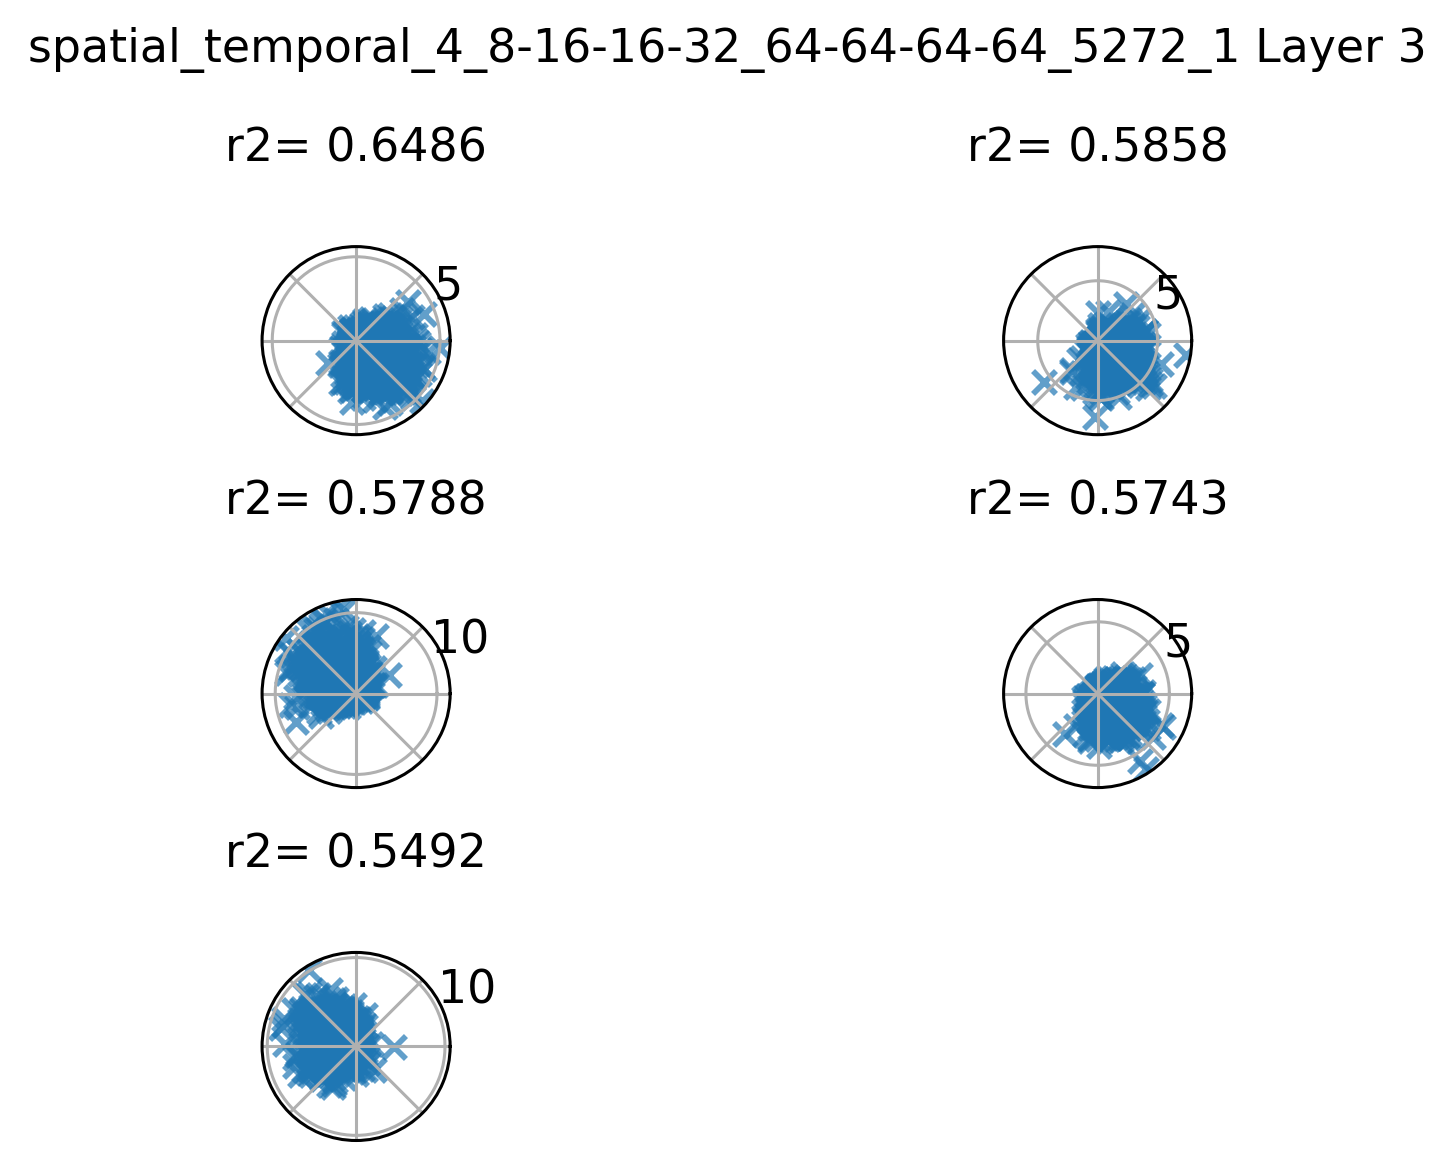

In [47]:
#fig, axs = plt.subplots(3,2)
#fig.title("%s Layer %d Polar Scatter Plots")

fig = plt.figure(dpi=275)

for k in range(kbest):         
    rowidx = dirmi[k]
    thetas, rs = get_thetas_rs_from_row(polar, lo, rowidx[0])
      
    randsel = np.random.permutation(len(thetas))[:2000]

    ax = fig.add_subplot(3, 2, k + 1, projection='polar')
    ax.scatter(thetas[randsel], rs[randsel], marker='x', alpha=0.7)
    ax.set_xticklabels([])
    
    ax.set_title("r2= %.4f" %rowidx[1])

#plt.subplots_adjust(top=0.3)
plt.tight_layout()
fig.suptitle("%s Layer %d" %(modelinfo['shortname'], ilayer), y = 1.05)
plt.show()

## B: 3D Polar Scatter Plots

In [49]:
def get_thetas_vms_rs_from_row(polar, acts, rowidx, tcoff=32):
    """Get matching thetas and activations (stored as Rs) 
    
    Arguments
    ---------
    polar : np.array [nr_samples, nr_components (speed, thetas), nr_timepoints], velocity vectors in polar representation
    acts : np.array, 3-dim for spindles and 4-dim for hidden layers, activation strength of units
    rowidx : tuple, 1-dim for spindles, 2-dim for hidden layers, which unit is being analyzed
    
    Returns
    -------
    thetas : np.array [nr_samples, nr_timepoints], theta component of velocity vector
    vms : np.array [nr_samples, nr_timepoints], speed component of velocity vector
    rs : np.array [nr_samples, nr_timepoints], activation strength of current unit
    """
    
    #select proper row
    vms = polar[:,0]
    thetas = polar[:,1]

    centers = get_centers(acts.shape[2])
    
    if(len(rowidx) == 1):
        nodeselector = (slice(None),) + rowidx
    else:
        nodeselector = (slice(None),) + tuple([rowidx[0]]) + (slice(None),) + tuple([rowidx[1]])
    
    #print(nodeselector)
    #print(acts.shape)
    acts = acts[nodeselector]
    
    #select time interval
    
    fmtcoff = sum(np.where(centers <= tcoff, True, False))
    
    thetas = thetas[:,centers[fmtcoff:len(centers) - fmtcoff]]
    vms = vms[:, centers[fmtcoff:len(centers) - fmtcoff]]
    acts = acts[:,fmtcoff:acts.shape[1]-fmtcoff]
    
    nnas = np.invert(np.isnan(thetas))
    
    thetas = thetas[nnas]
    vms = vms[nnas]
    #rs = acts[nodeselector].squeeze()
    rs = acts[nnas]
    
    return thetas, vms, rs

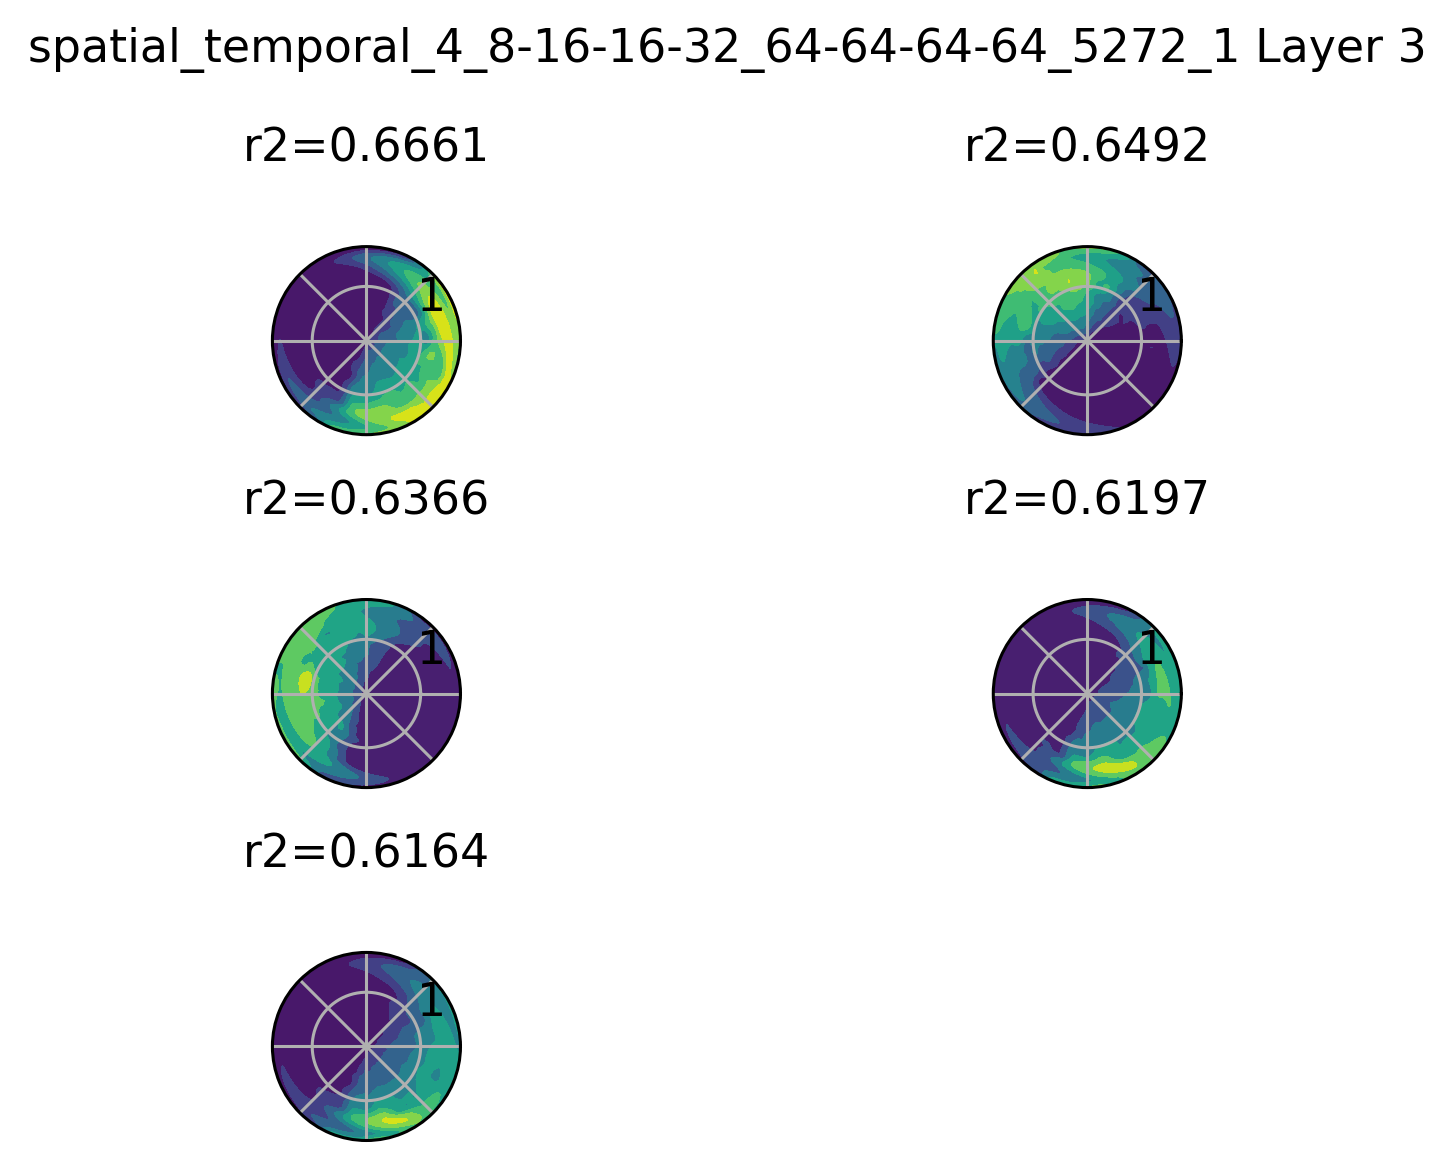

In [58]:
###output 3D polar plots
layer = lstring(ilayer)
lo = pickle.load(open(os.path.join(datafolder, lstring(ilayer - 1) + '.pkl'), 'rb'))
lo = lo[xyplmvt]

fig = plt.figure(dpi=275)

for k in range(kbest):
    rowidx = dvmi[k]
    thetas, vms, acts = get_thetas_vms_rs_from_row(polar, lo, rowidx[0])
    #dirvelplot(thetas, vms, rs, il, idx, k)
    
    ax = fig.add_subplot(3, 2, k+1, projection='polar')
    
    duplicate = np.where(thetas > np.pi/2)[0]
    thetasdpl = thetas[duplicate] - 2*np.pi
    vmsdpl = vms[duplicate]
    actsdpl = acts[duplicate]
    thetas = np.concatenate((thetas, thetasdpl))
    vms = np.concatenate((vms, vmsdpl))
    acts = np.concatenate((acts, actsdpl))
    
    ti = np.linspace(-3*np.pi/2, np.pi, 100)
    ri = np.linspace(0, vms.max(), 100)
    zi = griddata((thetas, vms), acts, (ti[None,:], ri[:, None]), method='linear')

    #cover non-reached points with value obtained by 'nearest'
    zinearest = griddata((thetas, vms), acts, (ti[None,:], ri[:, None]), method='nearest')
    #isnan = np.isnan(zi)
    isnan = np.isnan(zi[:,int(zi.shape[1]/20):int(zi.shape[1]*19/20)])
    zi[:,int(zi.shape[1]/20):int(zi.shape[1]*19/20)][isnan] = zinearest[:,int(zi.shape[1]/20):int(zi.shape[1]*19/20)][isnan]
    #smoothen with a gaussian filter
         
    kernelfactor = 0.5
    zi = gaussian_filter(zi, sigma=[2*np.pi*kernelfactor, vms.max()*kernelfactor])
    
    plt.contourf(ti, ri, zi)
        
    randsel = np.random.permutation(len(thetas))[:2000]
    thetas = thetas[randsel]
    vms = vms[randsel]
    
    ax.set_title("r2=%.4f" %rowidx[1])
    
    ax.set_xticklabels([])
    
fig.suptitle("%s Layer %d" %(modelinfo['shortname'], ilayer), y=1.05)
plt.tight_layout()
plt.show()

## C: Unit Classification

specify options

In [1]:
r2threshold = 0.2 #threshold above which units are counted as tuned for a particular feature

calculate number of neurons belonging in each category

In [67]:
nlayers = modelinfo['nlayers']
nlayers += 1
t_stride = 2
ntime=320
metrics = ['RMSE', 'r2', 'PCC']
nmetrics = len(metrics)
fset = 'vel'
mmod = 'std'
tcoff = 32

expf={
      'vel': runinfo.resultsfolder(modelinfo, 'vel'),
      'acc': runinfo.resultsfolder(modelinfo, 'acc'),
      'labels': runinfo.resultsfolder(modelinfo, 'labels')
}
# %% READ IN OF REGS AND THRESHOLD
bes = []

for ilayer in np.arange(0,nlayers):
    
    dvevals = np.load('%s/l%d_%s_mets_%s_%s_test.npy' %(expf['vel'], ilayer, 'vel', mmod, 'horall' ))        
    accevals = np.load('%s/l%d_%s_mets_%s_%s_test.npy' %(expf['acc'], ilayer, 'acc', mmod, 'horall'))
    labevals = np.load('%s/l%d_%s_mets_%s_%s_test.npy' %(expf['labels'], ilayer, 'labels', mmod, 'horall'))
    
    modevals = np.zeros(dvevals.shape[:len(dvevals.shape) - 2] + tuple([4]))
    modevals[...,0] = dvevals[...,1,1] #dir
    modevals[...,1] = dvevals[...,2,1] #vel
    modevals[...,2] = accevals[...,2,1] #acc
    modevals[...,3] = labevals[...,0,0] #labels
    
    modevals = np.where(modevals > r2threshold, True, False)
    
    bes.append(modevals)

# %% CLASSIFICATION
groupnames = ['Dir', 'Vel', 'Acc', 'Dir ∧ Vel', 'Dir ∧ Acc', 'Vel ∧ Acc', 'Dir ∧ Vel ∧ Acc', 'Labels', 'Total']

ncats = len(groupnames) - 1
cats = np.zeros((nlayers, ncats + 1))
for ilayer, be in enumerate(bes):
    #print("Layer %d" %ilayer)
    #be = be.squeeze()
    #print(be.shape)
    cats[ilayer, ncats] = be[...,0].size
    for irow, _ in np.ndenumerate(be[...,0]):
        b = np.squeeze(be[irow])
        #print(b.shape)
        if(sum(b[:3]) == sum(b)):
            if sum(b[:3]) == 1: #We evaluate the labels tuning separately
                ###ATTENTION! THIS WILL NOT WORK ACCURATELY IF CERTAIN LAYERS ARE TUNED FOR BOTH LABELS AND KIN FEATURES
                if(b[0] == 1):
                    cats[ilayer, 0] +=1
                elif(b[1] == 1):
                    cats[ilayer, 1] +=1
                elif(b[2] == 1):
                    cats[ilayer, 2] +=1
            elif sum(b[:3]) == 2:
                if(b[0] == 0):
                    cats[ilayer, 5] +=1
                elif(b[1] == 0):
                    cats[ilayer, 4] +=1
                elif(b[2] == 0):
                    cats[ilayer, 3] +=1 
            elif sum(b[:3]) == 3:
                cats[ilayer, 6] += 1
        else:
            print("Warning! Label Tuning")
            if(b[2] == 1):
                print("Warning! Also Acceleration tuned. Neuron double counted.")
                
            cats[ilayer, 7] +=1

#create modfractions
modfractions = (cats[:,:8].swapaxes(0,1) / cats[:,8]).swapaxes(0,1)

# %% OUTPUT TABLE
print(groupnames)
print(cats)

# %% ONLY DO S MODEL
#nmods = 1
nmods = ncats


Warning! Label Tuning
Warning! Label Tuning
['Dir', 'Vel', 'Acc', 'Dir ∧ Vel', 'Dir ∧ Acc', 'Vel ∧ Acc', 'Dir ∧ Vel ∧ Acc', 'Labels', 'Total']
[[ 24.   0.   0.   0.   0.   0.   0.   0.  25.]
 [ 55.   0.   0.  43.   0.   0.   0.   0. 104.]
 [ 18.   4.   0.  48.   0.  10.   8.   0. 112.]
 [ 11.   3.   0.  22.   0.   6.   7.   0.  64.]
 [  9.   7.   0.  15.   0.   2.  11.   0.  64.]
 [ 32.   6.   5.  23.   0.   6.   3.   0. 128.]
 [ 26.   9.   2.  14.   0.   1.   3.   0. 128.]
 [  7.   9.  10.   0.   0.   9.   0.   1. 128.]
 [  0.   1.   0.   0.   0.   0.   0.   1. 128.]]


plotting

In [74]:
def get_mtypecolorbar(mtype):
    """returns the needed colorbar for the given model type
    
    Arguments
    ---------
    mtype : str, one of ['Spatial-Temporal', 'Spatiotemporal']
    
    """
    if mtype=='Spatial-Temporal':
        cmap = matplotlib.cm.get_cmap('Blues_r') #spatial_temporal
    if mtype=='Spatiotemporal':
        cmap = matplotlib.cm.get_cmap('Greens_r') #spatiotemporal
    return cmap


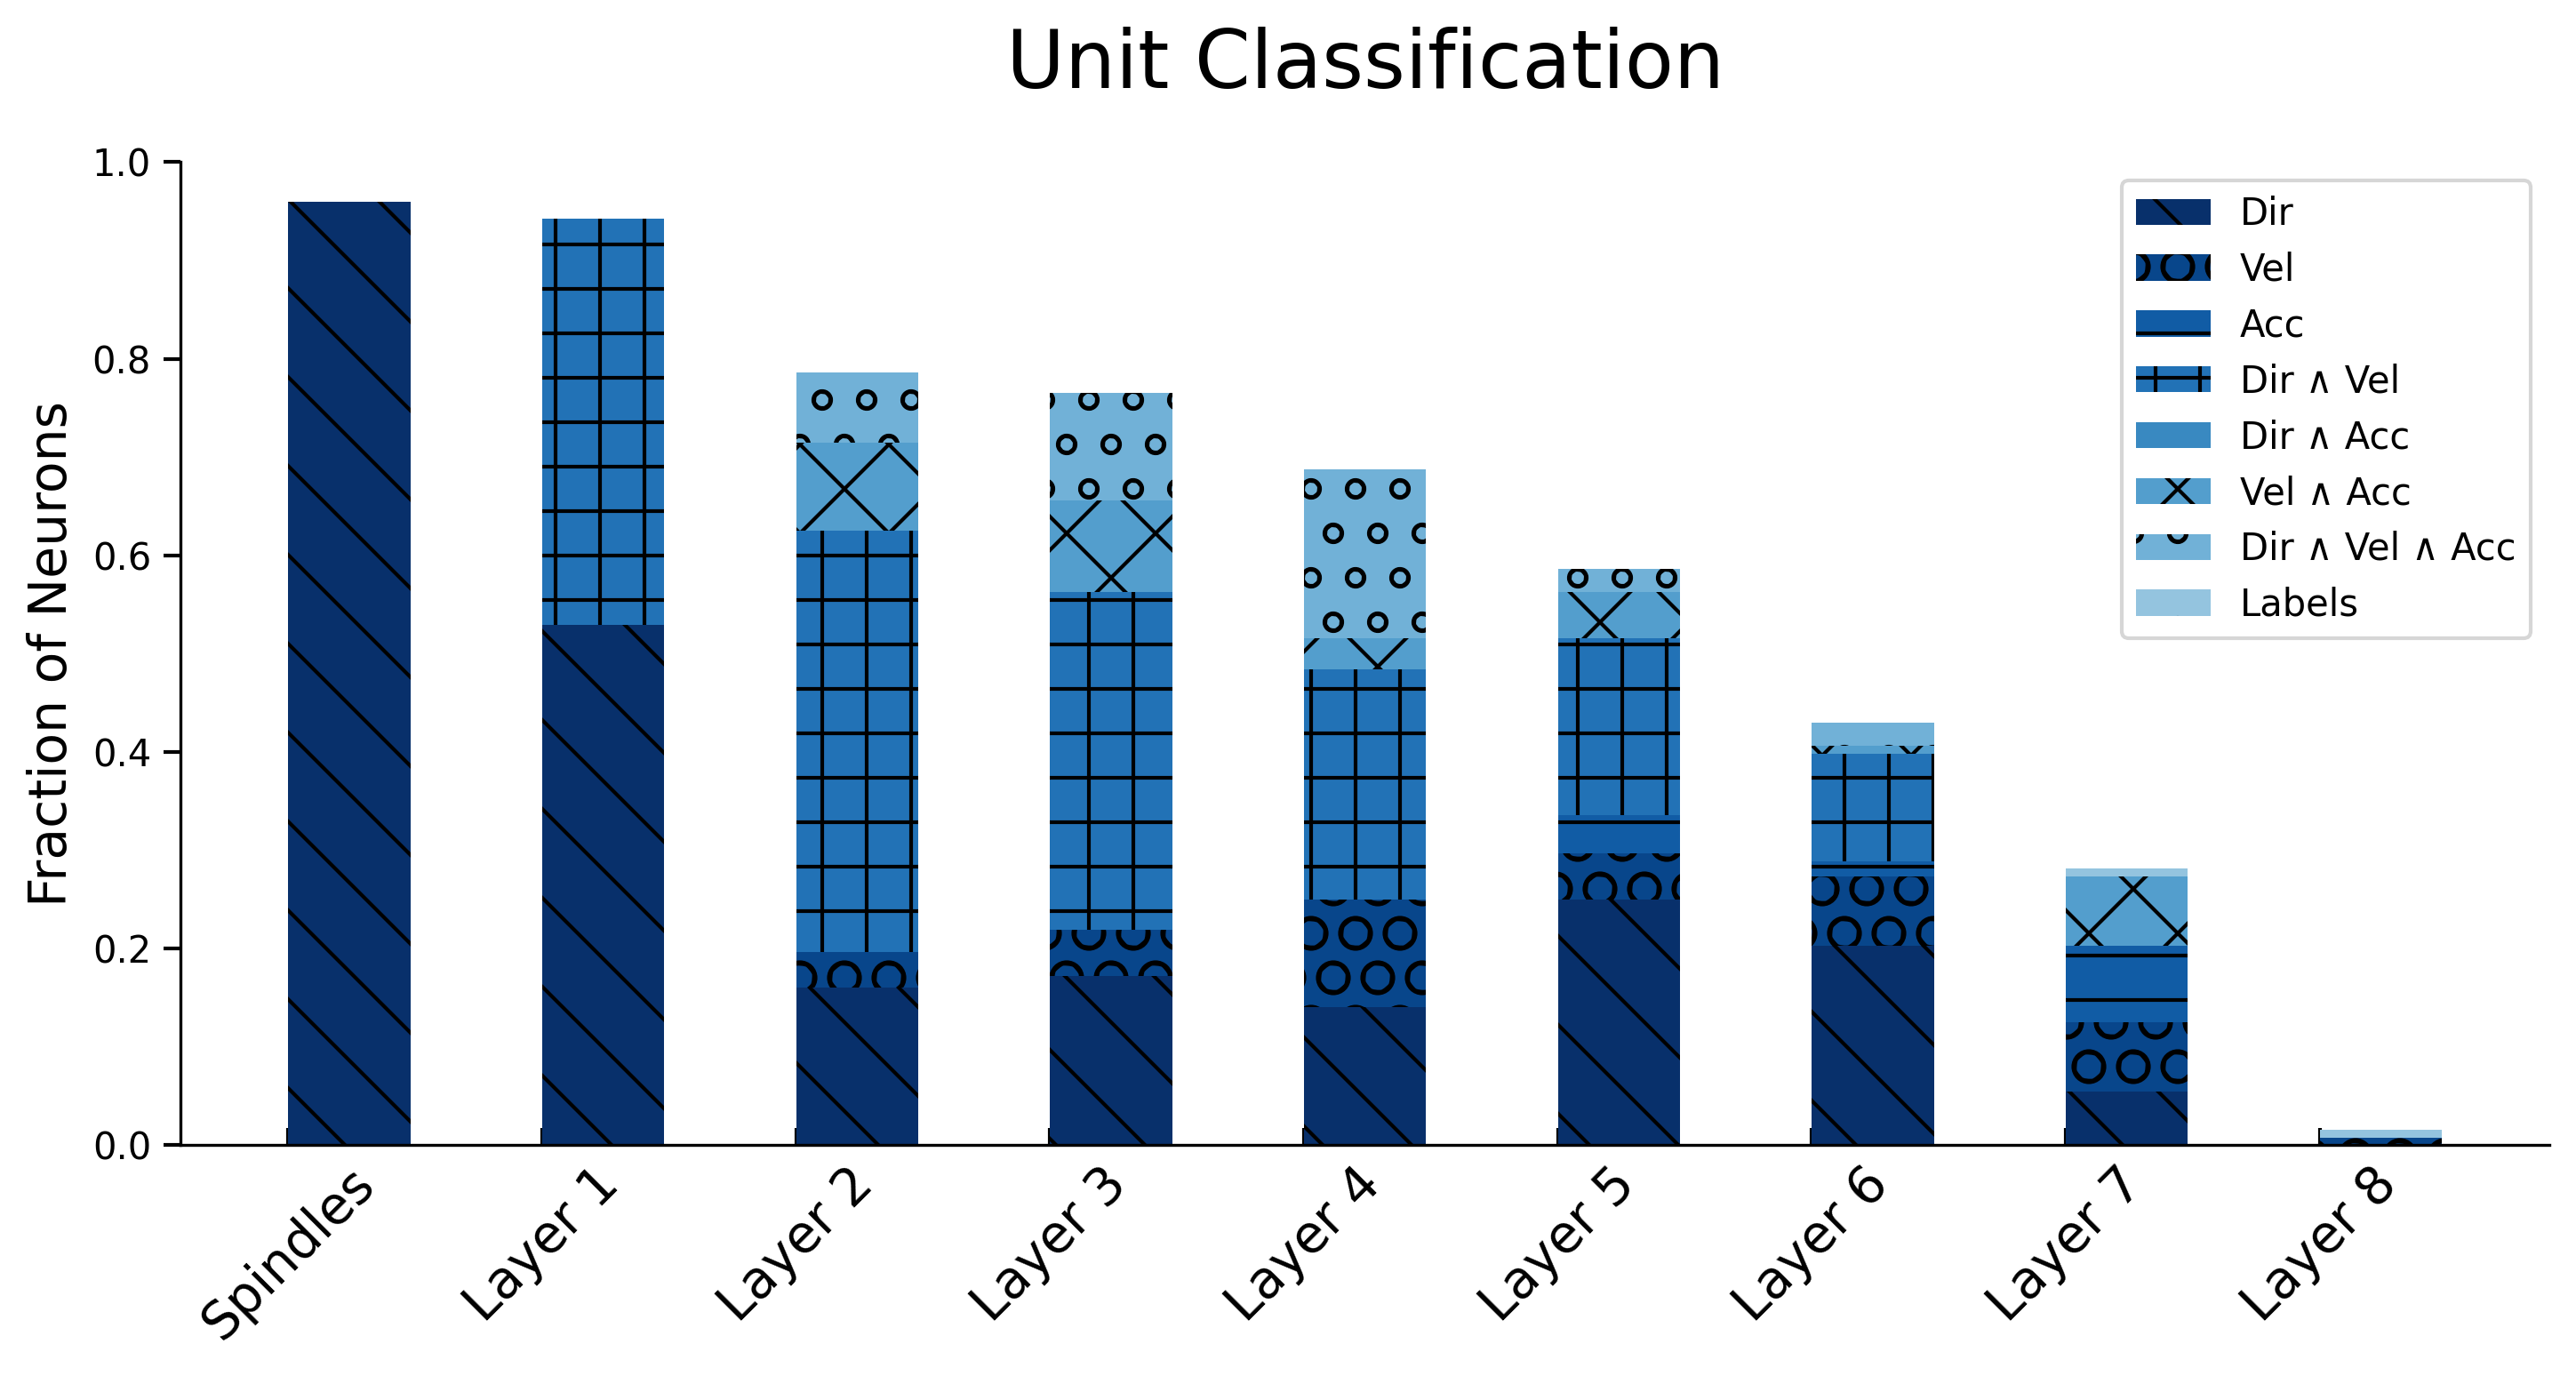

In [88]:
params = {
   'axes.labelsize': 14,
   'legend.fontsize': 10,
   'xtick.labelsize': 14,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [8,8 ],
   'font.size': 18,
   'axes.titlepad': 20,
   'ytick.major.size': 4.5,
   'ytick.major.width': 1,
   'ytick.minor.size': 3.5
   }

import matplotlib.patches as mpatches
plt.rcParams.update(params)

mtype = modfractions
nmtypes = 1

im = 0

# %% PLOT


space = 0.75
width = 0.6
lspace = space*nmtypes + 0.5

fig = plt.figure(figsize=(10, 5.5), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)  #allows turning off spines... i.e. top and right is good :)
ax.get_xaxis().tick_bottom()
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', length = 4.5, width=1)
ax.get_yaxis().tick_left()

#ax.tick_params(axis='y', length=0)
# offset the spines
#for spine in ax.spines.values():
#  spine.set_position(('outward', 5))
# put the grid behind
ax.set_axisbelow(True)

bars = []
ct = 0.4

#patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
patterns = ( '\\', 'O', '-', '+','','x','o', '.')

#for im, mtype in enumerate(modfractions):
#    positions=[ilayer*int((nlayers[0]-1)/(nlayers[im]-1))*lspace+space*im for ilayer in range(nlayers[im])]
positions=[ilayer*lspace+space*im for ilayer in range(nlayers)]

cmap = get_mtypecolorbar(modelinfo['shortbase'])
for icat in range(ncats):
    #print(im, icat, nlayers[im])
    #print(mtype)
    #print(len(positions))
    bars.append(plt.bar(positions, mtype[:,icat] ,\
            bottom = mtype[:,:icat].sum(axis=1), width=width,
            color = cmap(icat*(1-ct)/(nmods-1)),
            align='edge', hatch=patterns[icat]
            ))
    
#or ibar, bar in enumerate(bars):
#   bar.set_hatch(patterns[ibar])

plt.title('Unit Classification')
plt.xticks(np.arange(0,nlayers*lspace,lspace),
           ['Spindles'] + ['Layer %d' %i for i in np.arange(1,nlayers+1)],
           horizontalalignment='center', rotation=45)
plt.ylabel('Fraction of Neurons')
#plt.ylim(-0.1, 1.1)
plt.ylim(0,1)


#Creating the legend
modelpatches = [mpatches.Patch(color=get_mtypecolorbar(modelinfo['shortbase'])(1), label=mtype)]
#modellegend = plt.legend(modelpatches, modelnames, loc=(0.78,0.842425))
#ax.add_artist(modellegend)
plt.legend(bars, groupnames[:ncats], loc=1)

plt.tight_layout()

## D: Combined Violin Quantiles

In [91]:
def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
    
def clip(vp, lr):
    
    for b in vp['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
    
        if lr == 'l':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        elif lr == 'r':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)   

In [92]:
t_stride = 2
ntime=320
metrics = ['RMSE', 'r2', 'PCC']
nmetrics = len(metrics)
expid = 100
fset = 'vel'
mmod = 'std'
tcoff = 32

modnames = ['Dir', 'Vel', 'Dir x Vel', 'Acc', 'Labels']
nmods = len(modnames)

In [93]:
def get_modevals(model, runinfo):
    ''' Read in tuning curve fits from saved numpy files
    
    Arguments
    ---------
    model : dict, information about current model
    runinfo : RunInfo (extension of dict), information about experimental run
    
    Returns
    -------
    modevals : list of lists containing tuning curve test r2 strengths for five different model types to be plotted
        Outer list: layers; Inner list: Model types, containing np.array of r2 strengths
        
    '''
    
    expf={
          'vel': runinfo.resultsfolder(model, 'vel'),
          'acc': runinfo.resultsfolder(model, 'acc'),
          'labels': runinfo.resultsfolder(model, 'labels')
    }
    
    # READ IN OF REGS AND THRESHOLD, SAVE TEXT FILE
    modevals = []
    
    for i in range(nmods):
        modevals.append([])
    
    for ilayer in np.arange(0,model['nlayers'] + 1):
        
        dvevals = np.load(os.path.join(expf['vel'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'vel', mmod, runinfo.planestring())))
        accevals = np.load(os.path.join(expf['acc'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'acc', 'std',runinfo.planestring())))
        labevals = np.load(os.path.join(expf['labels'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'labels', 'std', runinfo.planestring())))
        
        modevals[0].append(dvevals[...,1,1]) #dir
        modevals[1].append(dvevals[...,2,1]) #vel
        modevals[2].append(dvevals[...,3,1]) #dir + vel
        modevals[3].append(accevals[...,2,1]) #acc
        modevals[4].append(labevals[:,0]) #labels
        
        
    return modevals

In [95]:
trainedmodel = modelinfo.copy()
trainedmodevals = get_modevals(trainedmodel, runinfo)

controlmodel = modelinfo.copy()
controlmodel['name'] = controlmodel['name'] + 'r'
controlmodevals = get_modevals(controlmodel, runinfo)

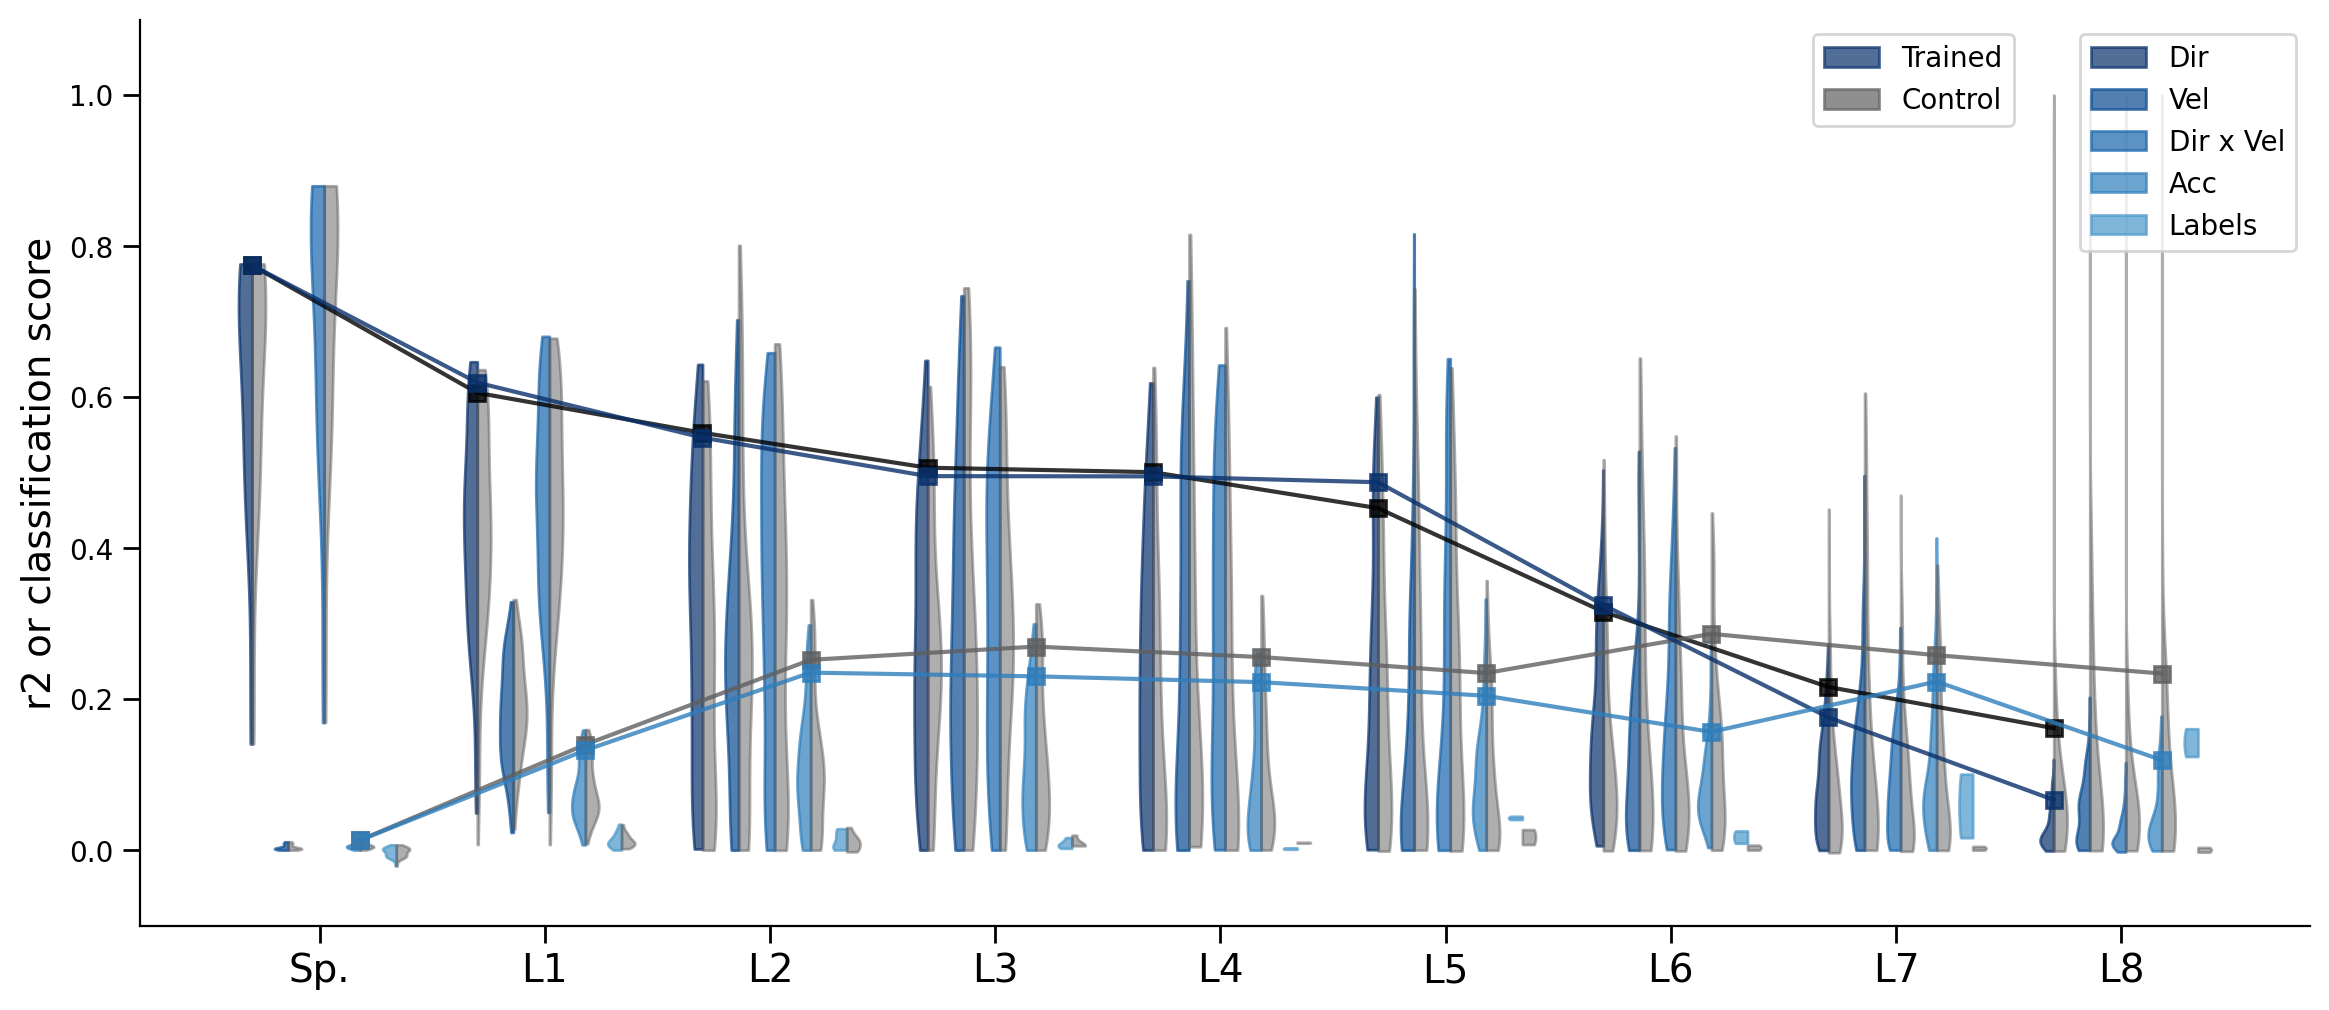

In [96]:
nlayers = trainedmodel['nlayers'] + 1

space = 0.8
width = 0.6
lspace = space*nmods + 1

trainedcmap = matplotlib.cm.get_cmap(trainedmodel['cmap']) #spatial_temporal    
controlcmap = matplotlib.cm.get_cmap('Greys_r') #spatial_temporal    
cmaps = [trainedcmap, controlcmap]

ct = 0.6
cidx = [i*(1-ct)/(nmods-1) for i in range(nmods)] #Blues_r option
#plot figure
fig = plt.figure(figsize=(14,6), dpi=200)
ax1 = fig.add_subplot(111)

plt.xticks(np.arange(lspace/2,nlayers*lspace + 1,lspace), 
           ['Sp.'] + ['L%d' %i for i in np.arange(1, nlayers+1)])

ax1.set_ylabel('r2 or classification score')
ax1.set_ylim(-0.1, 1.1)
vps = []
patches = []

ccolorindex = 3
for (modevals, cmap, alpha, zorder, lr) in zip([controlmodevals, trainedmodevals], [controlcmap, trainedcmap], [[0.8, 0.5], [0.8, 0.7]], [2,1], ['r', 'l']):
    for i, mod in enumerate(modevals):

        vp = ax1.violinplot(mod,
            positions=[ilayer*lspace+space*i+1 for ilayer in range(nlayers)], 
            showextrema = False,
            showmedians = False,
            showmeans = False,
            widths=width)

        for part in vp['bodies']:
            if lr == 'l':
                part.set_facecolor(cmap(cidx[i]))
                part.set_edgecolor(cmap(cidx[i]))
            else:
                part.set_facecolor(cmap(cidx[ccolorindex]))
                part.set_edgecolor(cmap(cidx[ccolorindex]))
            part.set_alpha(alpha[1])
            part.set_zorder(zorder)

        clip(vp, lr)

        patches.append(mpatches.Patch(color=cmap(cidx[i]), alpha=0.7))

        vps.append(vp)

    #Quantiles
    q = 0.9
    marker = 's'

    for i in [0,3]:
        mod = modevals[i]

        q90s = np.zeros((nlayers,))

        for ilayer, layer in enumerate(mod):
            q90s[ilayer] = np.quantile(layer, q)

        ax1.plot([ilayer*lspace+space*i+1 for ilayer in range(nlayers)], 
                  q90s, color=cmap(cidx[i]), marker=marker, alpha=alpha[0])

format_axis(plt.gca())
leg = plt.legend(patches[5:], modnames, loc='upper right')
ax1.add_artist(leg)
plt.legend([patches[5], patches[ccolorindex]], ['Trained', 'Control'], loc='upper right', bbox_to_anchor=(0.87, 1))

## E: Direction & Acceleration 90% Quantile Comparisons

In [107]:
analysisfolder = runinfo.sharedanalysisfolder(modelinfo, 'kindiffs')
df = pd.read_csv(os.path.join(analysisfolder, modelinfo['base'] + '_comparisons_df.csv'),
                 header=0, index_col=[0,1,2], dtype={'layer': int, 'mean': float, 'median': float})
tcfdf = df.loc[(slice(None), slice(None), ['dir', 'acc']), 'q90']
nlayers = modelinfo['nlayers']

In [110]:

def colorselector(cmapname, tcf, ct = 0.4):
    ''' Helper function to select color for kinematic tuning curve types and labels
    
    Arguments
    ---------
    cmapname : str, the name of the color map that is being used 
    tcf : str, name of tuning feature that is being plotted
    ct : int, opt, specifies range of colorbar that is used
    
    Returns
    -------
    color values
    '''
    
    tcnames = ['dir', 'vel', 'dirvel', 'acc', 'labels']
    nmods = len(tcnames)
    tci = tcnames.index(tcf)
    
    cmap = matplotlib.cm.get_cmap(cmapname)
    cidx = tci*(1-ct)/(nmods-1)
    return cmap(cidx)

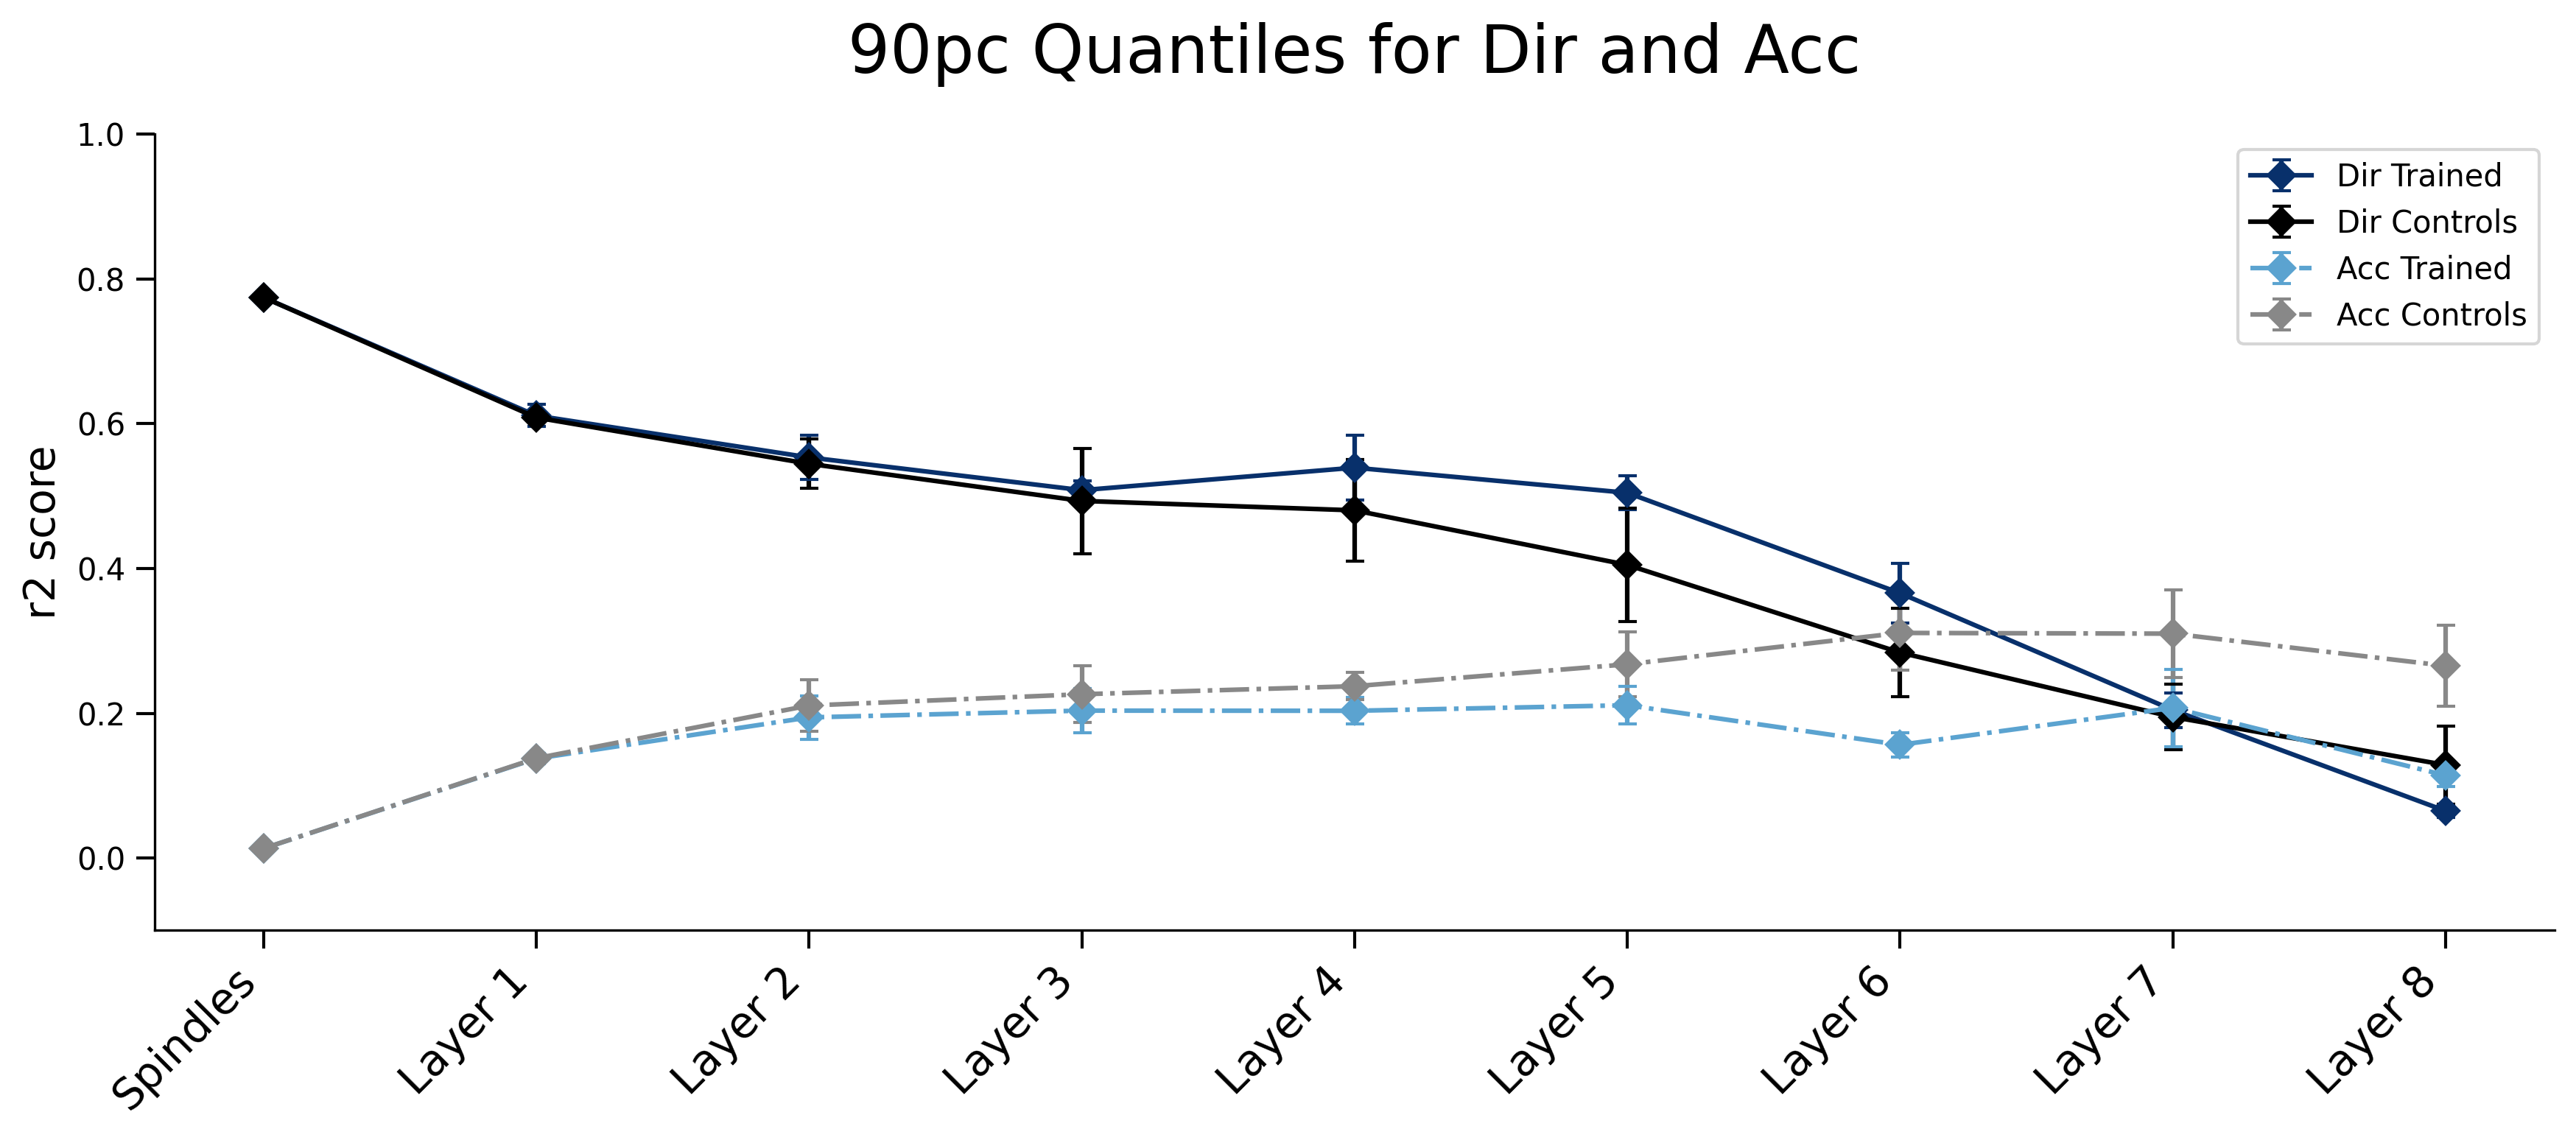

In [118]:
fig = plt.figure(figsize=(12,5.5), dpi=300)   
ax = fig.add_subplot(111)

trainednamer = lambda i: modelinfo['base'] + '_%d' %i
trainednames = [trainednamer(i) for i in np.arange(1,6)]

controlnamer = lambda i: modelinfo['base'] + '_%dr' %i
controlnames = [controlnamer(i) for i in np.arange(1,6)]

x = range(nlayers + 1)

#solution to calculate conf. interval of means from https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.t.html
from scipy.stats import t
t_corr = t.ppf(0.975, 4)

traineddirs = [tcfdf.loc[(trainednames, i, 'dir')].mean() for i in np.arange(nlayers+1)]
controldirs = [tcfdf.loc[(controlnames, i, 'dir')].mean() for i in np.arange(nlayers+1)]
errs_traineddirs = [tcfdf.loc[(trainednames, i, 'dir')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]
errs_controldirs = [tcfdf.loc[(controlnames, i, 'dir')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]

trainedlabels = [tcfdf.loc[(trainednames, i, 'acc')].mean() for i in np.arange(nlayers+1)]
controllabels = [tcfdf.loc[(controlnames, i, 'acc')].mean() for i in np.arange(nlayers+1)]
errs_trainedlabels = [tcfdf.loc[(trainednames, i, 'acc')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]
errs_controllabels = [tcfdf.loc[(controlnames, i, 'acc')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]

plt.errorbar(x, traineddirs, yerr=errs_traineddirs, color=colorselector(modelinfo['cmap'], 'dir'), marker='D', capsize=3.0)
plt.errorbar(x, controldirs, yerr=errs_controldirs, color=colorselector('Greys_r', 'dir'), marker='D', capsize=3.0)
plt.errorbar(x, trainedlabels, yerr=errs_trainedlabels, color=colorselector(modelinfo['cmap'], 'acc'), linestyle='-.',marker='D', capsize=3.0)
plt.errorbar(x, controllabels, yerr=errs_controllabels, color=colorselector('Greys_r', 'acc'), linestyle='-.', marker='D', capsize=3.0)
plt.ylabel('r2 score')
plt.xticks(np.array(x), ['Spindles'] + ['Layer %d' %i for i in np.arange(1,nlayers+1)], rotation=45,
           horizontalalignment = 'right')
plt.ylim((-0.1,1))

handles, _ = ax.get_legend_handles_labels()
handles = np.array(handles)
plt.legend(['Dir Trained', 'Dir Controls', \
            'Acc Trained', 'Acc Controls'])

ax = format_axis(ax)

plt.title('90pc Quantiles for Dir and Acc')
plt.tight_layout()